# Prerequisite

In [ ]:
# ## install finrl library
!pip install wrds
!pip install swig
!pip install -q condacolab
import condacolab
condacolab.install()
!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git


✨🍰✨ Everything looks OK!
  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-mkfrur3h
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-mkfrur3h
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit 5b7ac9c2cf149d134b440d40f48a0040f3423b5e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-mq0dc95j/elegantrl_3e8a1a95e6674bc09cd40f7309ca9569
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-mq0dc95j/elegantrl_3e8a1a95e6674bc09cd40f7309ca9569
  Resolved https://github.com/AI4Finance-Foundation/ElegantRL.git to commit a531d493b710a872a4943532872846e00ad96abf
  Preparing metadata (setup.py) ... done


In [ ]:
pip install yfinance pandas numpy matplotlib stockstats gym stable-baselines tensorflow pyfolio


In [ ]:
!git clone https://github.com/AI4Finance-Foundation/FinRL.git

fatal: destination path 'FinRL' already exists and is not an empty directory.


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

In [ ]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

# Data

In [ ]:
print(DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [ ]:
# TRAIN_START_DATE = '2009-04-01'
# TRAIN_END_DATE = '2021-01-01'
# TEST_START_DATE = '2021-01-01'
# TEST_END_DATE = '2022-06-01'

TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2021-10-01'
TEST_START_DATE = '2021-10-01'
TEST_END_DATE = '2023-03-01'

df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Shape of DataFrame:  (97013, 8)


In [ ]:
# Modify this cell to take user input for the stock ticker
import sys

ticker_input = input("Enter the stock ticker you want to trade (e.g., AAPL): ")
if not ticker_input:
    print("No ticker provided, using default DOW_30_TICKER")
    ticker_list = DOW_30_TICKER
else:
    ticker_list = [ticker_input.upper()]

print(f"Trading the following ticker(s): {', '.join(ticker_list)}")

df = YahooDownloader(start_date=TRAIN_START_DATE,
                     end_date=TEST_END_DATE,
                     ticker_list=ticker_list).fetch_data()

Enter the stock ticker you want to trade (e.g., AAPL): AAPL


[*********************100%%**********************]  1 of 1 completed

Trading the following ticker(s): AAPL
Shape of DataFrame:  (3311, 8)


In [ ]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2010-01-04,7.622500,7.660714,7.585000,6.470740,493729600,AAPL,0
1,2010-01-05,7.664286,7.699643,7.616071,6.481929,601904800,AAPL,1
2,2010-01-06,7.656429,7.686786,7.526786,6.378824,552160000,AAPL,2
3,2010-01-07,7.562500,7.571429,7.466071,6.367032,477131200,AAPL,3
4,2010-01-08,7.510714,7.571429,7.466429,6.409362,447610800,AAPL,4


In [ ]:
df.tail()

,date,open,high,low,close,volume,tic,day
3306,2023-02-22,148.869995,149.949997,147.160004,148.119385,51011300,AAPL,2
3307,2023-02-23,150.089996,150.339996,147.240005,148.606796,48394200,AAPL,3
3308,2023-02-24,147.110001,147.190002,145.720001,145.931076,55469600,AAPL,4
3309,2023-02-27,147.710007,149.169998,147.449997,147.134628,44998500,AAPL,0
3310,2023-02-28,147.050003,149.080002,146.830002,146.627335,50547000,AAPL,1


In [ ]:
df.shape

(3311, 8)

In [ ]:
df.sort_values(['date','tic']).head()

,date,open,high,low,close,volume,tic,day
0,2010-01-04,7.622500,7.660714,7.585000,6.470740,493729600,AAPL,0
1,2010-01-05,7.664286,7.699643,7.616071,6.481929,601904800,AAPL,1
2,2010-01-06,7.656429,7.686786,7.526786,6.378824,552160000,AAPL,2
3,2010-01-07,7.562500,7.571429,7.466071,6.367032,477131200,AAPL,3
4,2010-01-08,7.510714,7.571429,7.466429,6.409362,447610800,AAPL,4


In [ ]:
len(df.tic.unique())

1

In [ ]:
df.tic.value_counts()

tic
AAPL    3311
Name: count, dtype: int64

# Process the data


In [ ]:
 INDICATORS = ['macd',
               'rsi_30',
               'cci_30',
               'dx_30']

In [ ]:
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)

Successfully added technical indicators
Successfully added turbulence index


In [ ]:
processed.sample(5)

,date,open,high,low,close,volume,tic,day,macd,rsi_30,cci_30,dx_30,turbulence
1342,2015-05-05,32.037498,32.112499,31.445000,28.227282,197085600,AAPL,1,0.124922,50.812682,-8.750371,11.725098,3.227783
86,2010-05-07,8.703929,8.806071,8.043214,7.131391,1676018400,AAPL,4,0.121426,49.159565,-75.722527,49.257651,0.000000
2906,2021-07-21,145.529999,146.130005,144.630005,143.150528,74993500,AAPL,2,3.926214,61.316189,84.378457,27.725861,0.102709
2307,2019-03-06,43.667500,43.872501,43.485001,42.002560,83241600,AAPL,2,0.746554,53.265103,72.429155,31.719749,0.097658
437,2011-09-27,14.597500,14.616071,14.216429,12.071904,632497600,AAPL,1,0.226919,56.376938,94.169453,5.203847,0.539521


# Environmnet

In [ ]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 1, State Space: 7


In [ ]:
env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
    "print_verbosity":5

}

In [ ]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

ensemble_agent = DRLEnsembleAgent(df=processed,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TEST_START_DATE,TEST_END_DATE),
                 rebalance_window=rebalance_window,
                 validation_window=validation_window,
                 **env_kwargs)



In [ ]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.005,
                    'learning_rate': 0.0007
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 10000,
                      "learning_rate": 0.0005,
                      "batch_size": 64
                    }
# Corrected code

# Define TD3_model_kwargs
TD3_model_kwargs = {
    "buffer_size": 10000,
    "learning_starts": 100,
    "batch_size": 100,
}

# Define SAC_model_kwargs
SAC_model_kwargs = {
    "buffer_size": 1000,
    "learning_starts": 1000,
    "batch_size": 128,
    "ent_coef": "auto",
}

# Define timesteps_dict
timesteps_dict = {
    "a2c": 1000,
    "ppo": 1000,
    "ddpg": 1000,
    "sac": 1000,
    "td3": 1000,
}

# Call run_ensemble_strategy method
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                  PPO_model_kwargs,
                                                  DDPG_model_kwargs,
                                                  SAC_model_kwargs,
                                                  TD3_model_kwargs,
                                                  timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  13.862712353508398
======Model training from:  2010-01-01 to  2021-10-04
======a2c Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007}
Using cpu device
Logging to tensorboard_log/a2c/a2c_126_3
----------------------------------------
| time/                 |              |
|    fps                | 253          |
|    iterations         | 100          |
|    time_elapsed       | 1            |
|    total_timesteps    | 500          |
| train/                |              |
|    entropy_loss       | -1.49        |
|    explained_variance | -1.19e-07    |
|    learning_rate      | 0.0007       |
|    n_updates          | 99           |
|    policy_loss        | -0.00607     |
|    reward             | 0.0059541464 |
|    std                | 1.08         |
|    value_loss         | 9.72e-05     |
----------------------------------------
--------------------------------------
| time/          

In [ ]:
df_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe,SAC Sharpe,TD3 Sharpe
0,126,2021-10-04,2022-01-03,A2C,0.294395,0.159056,0.0,0.0,0.0
1,189,2022-01-03,2022-04-04,DDPG,-0.137305,-0.036442,0.143971,0.0,0.0
2,252,2022-04-04,2022-07-06,DDPG,-0.128936,-0.084619,0.0,0.0,0.0
3,315,2022-07-06,2022-10-04,DDPG,-0.252374,-0.136582,0.0,0.0,-0.2319


# Backtesting

In [ ]:
!pip install pandas
import pandas as pd

In [ ]:
unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()

In [ ]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = pd.concat([df_account_value, temp], ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  -0.11285772052731816


In [ ]:
df_account_value.head(10)

,account_value,date,daily_return,datadate
0,1000000.000000,2022-01-03,NaN,2022-01-03
1,999753.926956,2022-01-04,-2.460730e-04,2022-01-04
2,998899.928856,2022-01-05,-8.542083e-04,2022-01-05
3,998206.388647,2022-01-06,-6.943040e-04,2022-01-06
4,998246.142393,2022-01-07,3.982518e-05,2022-01-07
5,998246.274491,2022-01-10,1.323300e-07,2022-01-10
6,998854.478616,2022-01-11,6.092726e-04,2022-01-11
7,998953.074582,2022-01-12,9.870904e-05,2022-01-12
8,997863.870804,2022-01-13,-1.090345e-03,2022-01-13
9,998167.260722,2022-01-14,3.040394e-04,2022-01-14


<Axes: >

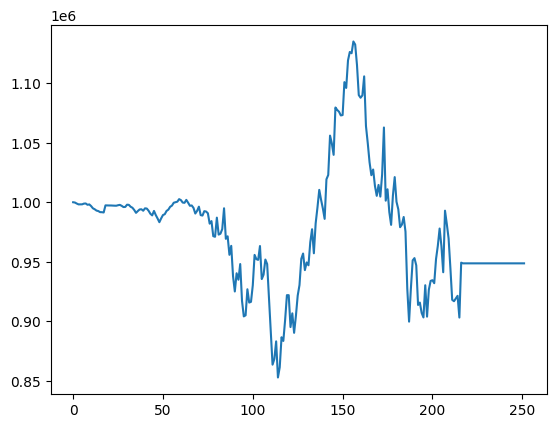

In [ ]:
%matplotlib inline
df_account_value.account_value.plot()

In [ ]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return         -0.051295
Cumulative returns    -0.051295
Annual volatility      0.231561
Sharpe ratio          -0.112858
Calmar ratio          -0.247548
Stability              0.044151
Max drawdown          -0.207210
Omega ratio            0.977161
Sortino ratio         -0.158863
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.896415
Daily value at risk   -0.029278
dtype: float64


In [ ]:
#baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI",
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(df_dji_, value_col_name = 'close')

[*********************100%%**********************]  1 of 1 completed

==============Get Baseline Stats===========
Shape of DataFrame:  (251, 8)
Annual return         -0.094324
Cumulative returns    -0.093968
Annual volatility      0.198502
Sharpe ratio          -0.402058
Calmar ratio          -0.429901
Stability              0.236972
Max drawdown          -0.219408
Omega ratio            0.936015
Sortino ratio         -0.559755
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.014390
Daily value at risk   -0.025326
dtype: float64


In [ ]:
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value['date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji+.csv")

df_account_value.to_csv('df_account_value.csv')


df_dji:             date           dji
0    2022-01-03  1.000000e+06
1    2022-01-04  1.005866e+06
2    2022-01-05  9.951360e+05
3    2022-01-06  9.904718e+05
4    2022-01-07  9.903404e+05
..          ...           ...
247  2022-12-27  9.086102e+05
248  2022-12-28  8.986103e+05
249  2022-12-29  9.080428e+05
250  2022-12-30  9.060324e+05
251  2023-01-03           NaN

[252 rows x 2 columns]
df_dji:                       dji
date                    
2022-01-03  1.000000e+06
2022-01-04  1.005866e+06
2022-01-05  9.951360e+05
2022-01-06  9.904718e+05
2022-01-07  9.903404e+05
...                  ...
2022-12-27  9.086102e+05
2022-12-28  8.986103e+05
2022-12-29  9.080428e+05
2022-12-30  9.060324e+05
2023-01-03           NaN

[252 rows x 1 columns]


df_result_ensemble.columns:  Index(['ensemble'], dtype='object')
df_trade_date:         datadate
0    2021-10-04
1    2021-10-05
2    2021-10-06
3    2021-10-07
4    2021-10-08
..          ...
348  2023-02-22
349  2023-02-23
350  2023-02-24
351  2023-02-27
352  2023-02-28

[353 rows x 1 columns]
df_result_ensemble:                    ensemble
date                      
2022-01-03  1000000.000000
2022-01-04   999753.926956
2022-01-05   998899.928856
2022-01-06   998206.388647
2022-01-07   998246.142393
...                    ...
2022-12-27   948705.426018
2022-12-28   948705.426018
2022-12-29   948705.426018
2022-12-30   948705.426018
2023-01-03   948705.426018

[252 rows x 1 columns]
==============Compare to DJIA===========
result:                    ensemble           dji
date                                    
2022-01-03  1000000.000000  1.000000e+06
2022-01-04   999753.926956  1.005866e+06
2022-01-05   998899.928856  9.951360e+05
2022-01-06   998206.388647  9.904718e+05
2022-01-07 

<Figure size 1500x500 with 0 Axes>

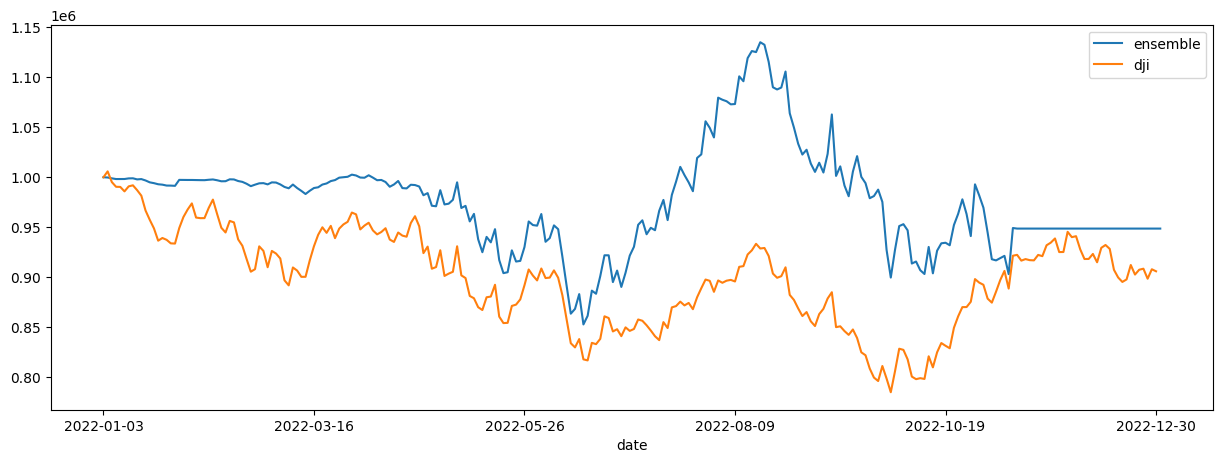

In [ ]:


# print("==============Compare to DJIA===========")
# %matplotlib inline
# # S&P 500: ^GSPC
# # Dow Jones Index: ^DJI
# # NASDAQ 100: ^NDX
# backtest_plot(df_account_value,
#               baseline_ticker = '^DJI',
#               baseline_start = df_account_value.loc[0,'date'],
#               baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])
df.to_csv("df.csv")
df_result_ensemble = pd.DataFrame({'date': df_account_value['date'], 'ensemble': df_account_value['account_value']})
df_result_ensemble = df_result_ensemble.set_index('date')

print("df_result_ensemble.columns: ", df_result_ensemble.columns)

# df_result_ensemble.drop(df_result_ensemble.columns[0], axis = 1)
print("df_trade_date: ", df_trade_date)
# df_result_ensemble['date'] = df_trade_date['datadate']
# df_result_ensemble['account_value'] = df_account_value['account_value']
df_result_ensemble.to_csv("df_result_ensemble.csv")
print("df_result_ensemble: ", df_result_ensemble)
print("==============Compare to DJIA===========")
result = pd.DataFrame()
# result = pd.merge(result, df_result_ensemble, left_index=True, right_index=True)
# result = pd.merge(result, df_dji, left_index=True, right_index=True)
result = pd.merge(df_result_ensemble, df_dji, left_index=True, right_index=True)
print("result: ", result)
result.to_csv("result.csv")
result.columns = ['ensemble', 'dji']

%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();

In [ ]:
import plotly.graph_objects as go

# Combine the ensemble strategy and Dow Jones Index into a single DataFrame
combined_df = pd.DataFrame({'Ensemble Strategy': df_result_ensemble['ensemble'],
                            'Dow Jones Index': df_dji['dji']},
                           index=df_result_ensemble.index)

# Create a Plotly figure
fig = go.Figure()

# Add traces for the ensemble strategy and Dow Jones Index
fig.add_trace(go.Scatter(x=combined_df.index, y=combined_df['Ensemble Strategy'], mode='lines', name='Ensemble Strategy'))
fig.add_trace(go.Scatter(x=combined_df.index, y=combined_df['Dow Jones Index'], mode='lines', name='Dow Jones Index'))

# Update layout
fig.update_layout(title='Backtesting Results: Ensemble Strategy vs Dow Jones Index',
                  xaxis_title='Date',
                  yaxis_title='Portfolio Value',
                  height=600)

# Show the figure
fig.show()